# MAPPING FLOODWATER FROM RADAR IMAGERY USING SEMANTIC SEGMENTATION

## Environment setup

### Install Relevant Libraries

In [1]:
!pip install watermark
!pip install pandas-path
!pip install -U albumentations
!pip install pytorch-lightning
!pip install segmentation-models-pytorch

  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Using cached albumentations-1.0.2-py3-none-any.whl (98 kB)


In [2]:
%load_ext watermark
# %matplotlib

In [3]:
# %watermark -v

In [4]:
import pandas as pd
pd.__version__

'1.2.5'

In [5]:
# Downgrade pandas to allow compatibility with pytorch_lightning
# !pip install --upgrade pandas==1.2.5 

## Data

In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This is where our downloaded images and metadata live locally
DATA_PATH = Path().cwd().parent

In [7]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [8]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [9]:
train_metadata.flood_id.value_counts()

hbe    138
pxs    136
jja    132
kuo    130
tnp    106
qxb     84
wvy     64
tht     60
qus     60
coz     56
hxu     52
ayt     36
awc     30
Name: flood_id, dtype: int64

In [10]:
train_metadata.shape

(1084, 6)

In [11]:
train_metadata.chip_id.nunique()

542

In [12]:
# Chips per flood id
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

In [13]:
# Chips per location
location_counts = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

Text(0.5, 1.0, 'Number of Chips by Location')

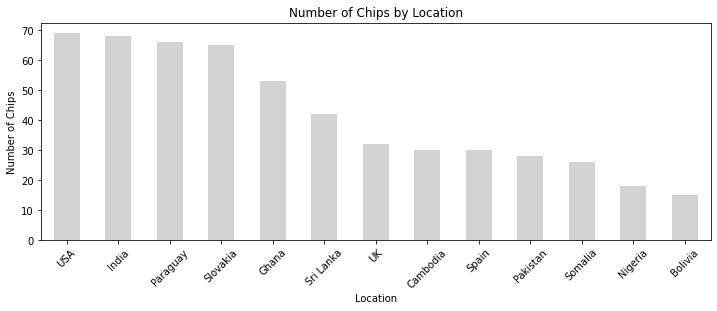

In [14]:
plt.figure(figsize=(12, 4))
location_counts.plot(kind="bar", color="lightgray")
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Chips by Location")

In [15]:
## Year of capture
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year)["flood_id"].nunique()
year_counts

scene_start
2016    1
2017    2
2018    6
2019    3
2020    1
Name: flood_id, dtype: int64

- Events captured from 2016 to 2020.

In [16]:
train_metadata.groupby("flood_id")["scene_start"].nunique()

flood_id
awc    1
ayt    1
coz    1
hbe    1
hxu    1
jja    1
kuo    1
pxs    1
qus    1
qxb    1
tht    1
tnp    1
wvy    1
Name: scene_start, dtype: int64

## Images

In [17]:
from pandas_path import path

In [18]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

In [19]:
train_metadata["feature_path"].head(5)

0    /home/jovyan/PlanetaryComputerExamples/competi...
1    /home/jovyan/PlanetaryComputerExamples/competi...
2    /home/jovyan/PlanetaryComputerExamples/competi...
3    /home/jovyan/PlanetaryComputerExamples/competi...
4    /home/jovyan/PlanetaryComputerExamples/competi...
Name: feature_path, dtype: object

In [20]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [21]:
train_metadata["label_path"].head(5)

0    /home/jovyan/PlanetaryComputerExamples/competi...
1    /home/jovyan/PlanetaryComputerExamples/competi...
2    /home/jovyan/PlanetaryComputerExamples/competi...
3    /home/jovyan/PlanetaryComputerExamples/competi...
4    /home/jovyan/PlanetaryComputerExamples/competi...
Name: label_path, dtype: object

In [22]:
import rasterio

In [23]:
# Examine an arbitrary image
image_path = train_metadata.feature_path[0]
with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  # read a single band

In [24]:
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32720),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

In [25]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [26]:
data.shape

(512, 512)

In [27]:
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()

In [28]:
with rasterio.open(image_path) as img:
    numpy_mask = img.read(1, masked=True)
numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

## Visualization

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)

In [31]:
def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]
    
    return scale_img(img)

In [32]:
def create_false_color_composite_(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]
    
    return scale_img(img)

In [33]:
def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    chip_df = train_metadata[train_metadata.chip_id == random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

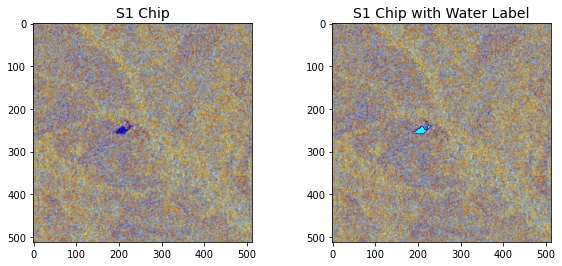

In [34]:
display_random_chip(23)

Very little flood water coverage.

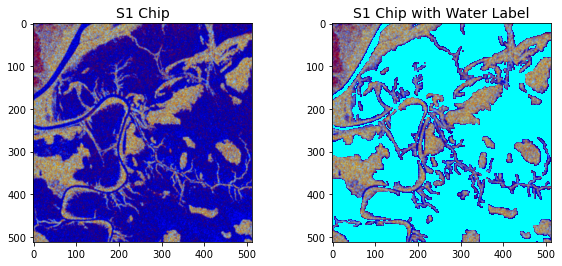

In [35]:
display_random_chip(66)

High flood water coverage.

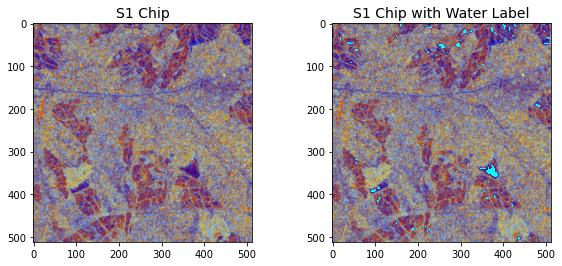

In [36]:
display_random_chip(98)

Fairly little flood water coverage.

In [37]:
# Image size
examples = [rasterio.open(train_metadata.feature_path[x]) for x in range(5)]
for image in examples:
    print(image.shape)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


## Training/Validation Sets

- Individual flood events are independent.

In [38]:
import random

In [39]:
train_metadata.flood_id.value_counts()

hbe    138
pxs    136
jja    132
kuo    130
tnp    106
qxb     84
wvy     64
tht     60
qus     60
coz     56
hxu     52
ayt     36
awc     30
Name: flood_id, dtype: int64

In [40]:
random.seed(9)  # set a seed for reproducibility

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [41]:
val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [42]:
val.shape, train.shape

((352, 8), (732, 8))

A single input to the model contains both VV and VH bands, indentify input by `chip_id`.

In [43]:
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.
    Args:
        image_level_df (pd.DataFrame): image-level dataframe
    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

In [44]:
train_metadata.columns

Index(['image_id', 'chip_id', 'flood_id', 'polarization', 'location',
       'scene_start', 'feature_path', 'label_path'],
      dtype='object')

In [45]:
train_metadata.head(3)

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,/home/jovyan/PlanetaryComputerExamples/competi...,/home/jovyan/PlanetaryComputerExamples/competi...
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,/home/jovyan/PlanetaryComputerExamples/competi...,/home/jovyan/PlanetaryComputerExamples/competi...
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,/home/jovyan/PlanetaryComputerExamples/competi...,/home/jovyan/PlanetaryComputerExamples/competi...


In [46]:
train_metadata.label_path[:2]

0    /home/jovyan/PlanetaryComputerExamples/competi...
1    /home/jovyan/PlanetaryComputerExamples/competi...
Name: label_path, dtype: object

In [47]:
# Separate features from labels
val_x = get_paths_by_chip(val)
# Drop one label for each id, as it is a duplicate.
val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train)
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [48]:
# Validation size
# Confirm approx. 1/3 of images are in the validation set
len(val_x) / (len(val_x) + len(train_x)) * 100

32.47232472324723

## Baseline Model

### Custom Dataset (PyTorch)
The dataset object returns samples as dictionaries with keys for:
- `chip_id`: the chip id
- `chip`: a two-band image tensor (VV and VH)
- `label`: the label mask, if it exists

In [49]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [78]:
class FloodDataset(Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """
    def __init__(self, x_paths, y_paths=None, transforms=None):
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ndx):
        # Loads a 2-channel image from a chip-level dataframe.
        instance = self.data.loc[ndx]
        
        # Read VV/VH bands
        with rasterio.open(instance.vv_path) as vv:
            vv_band = vv.read(1)
        with rasterio.open(instance.vh_path) as vh:
            vh_band = vh.read(1)
            
        # Stack arrays along the last dimension
        chip_x = np.stack((vv_band, vh_band), axis=-1)
        
        # Scale by min/max
        min_norm = -77
        max_norm = 26
        chip_x = np.clip(chip_x, min_norm, max_norm)
        chip_x = (chip_x - min_norm) / (max_norm - min_norm)
        
        # Apply data augmentations, if any.
        if self.transforms:
            chip_x = self.transforms(image=chip_x)["image"]
        chip_x = np.transpose(chip_x, [2, 0, 1])
        
        # Prepare sample dictionary
        sample = {"chip_id": instance.chip_id, "chip": chip_x}
        
        # Load label if available.
        if self.label is not None:
            label_path = self.label.loc[ndx].label_path
            with rasterio.open(label_path) as lp:
                chip_y = lp.read(1)
            # Apply data argumentations to label
            if self.transforms:
                chip_y = self.transforms(image=chip_y)["image"]
            sample["label"] = chip_y
            
        return sample

## Data Augmentations

Counter overfitting by increasing the size of training data by applying a set of data augmentations.

In [79]:
import albumentations

In [80]:
# These transformations will be passed to the model class
training_transformations = albumentations.Compose(
    [
        albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)

In [81]:
# Define the loss function
class XEDiceLoss(torch.nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """
    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where((true == 255), 0, true)  # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)

In [82]:
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

## Model
A baseline model that takes radar imagery as input and outputs binary masks that indicate which pixels in a scene contain floodwater.

In [83]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

In [84]:
# Model definition
class FloodModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.output_path = self.hparams.get("output_path", "model-outputs")
        self.gpu = self.hparams.get("gpu", False)
        self.transform = training_transformations

        # Save model artefacts
        self.output_path = Path.cwd() / self.output_path
        self.output_path.mkdir(exist_ok=True)

        # Track validation IOU.
        self.intersection = 0
        self.union = 0

        # Instantiate datasets, model, and trainer params
        self.train_dataset = FloodDataset(
            self.x_train, self.y_train, transforms=self.transform
        )
        self.val_dataset = FloodDataset(self.x_val, self.y_val, transforms=None)
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()

    ## LightningModule methods
    def forward(self, image):
        # Forward pass
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Calculate training loss
        criterion = XEDiceLoss()
        xe_dice_loss = criterion(preds, y)

        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss",
            xe_dice_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union

        # Log batch IOU
        batch_iou = intersection / union
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Define scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=self.patience
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "val_loss",
        }  # logged value to monitor
        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        # Calculate IOU at end of epoch
        epoch_iou = self.intersection / self.union

        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0

        # Log epoch validation IOU
        self.log("val_loss", epoch_iou, on_epoch=True, prog_bar=True, logger=True)
        return epoch_iou

    ## Convenience Methods ##

    def _prepare_model(self):
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=2,
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()
        return unet_model

    def _get_trainer_params(self):
        # Define callback behavior
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor="val_loss",
            mode="max",
            verbose=True,
        )
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss",
            patience=(self.patience * 3),
            mode="max",
            verbose=True,
        )

        # Specify where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "tensorboard-logs")
        self.log_path.mkdir(exist_ok=True)
        logger = pl.loggers.TensorBoardLogger(self.log_path, name="benchmark-model")

        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": logger,
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.hparams.get("fast_dev_run", False),
            "num_sanity_val_steps": self.hparams.get("val_sanity_checks", 0),
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

## Fit The Model

In [85]:
# Set the hyper parameters
hparams = {
    # Required hparams
    "x_train": train_x,
    "x_val": val_x,
    "y_train": train_y,
    "y_val": val_y,
    # Optional hparams
    "backbone": "resnet34",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 1000,
    "patience": 4,
    "batch_size": 32,
    "num_workers": 0,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model-outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
}

In [86]:
flood_model = FloodModel(hparams=hparams)
flood_model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.734    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.033
Epoch 0, global step 11: val_loss reached 0.03327 (best 0.03327), saving model to "/home/jovyan/PlanetaryComputerExamples/competitions/s1floods/FloodwaterMapping/model-outputs/epoch=0-step=11.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.103
Epoch 1, global step 23: val_loss reached 0.10323 (best 0.10323), saving model to "/home/jovyan/PlanetaryComputerExamples/competitions/s1floods/FloodwaterMapping/model-outputs/epoch=1-step=23.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.181 >= min_delta = 0.0. New best score: 0.284
Epoch 2, global step 35: val_loss reached 0.28433 (best 0.28433), saving model to "/home/jovyan/PlanetaryComputerExamples/competitions/s1floods/FloodwaterMapping/model-outputs/epoch=2-step=35.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.285
Epoch 3, global step 47: val_loss reached 0.28496 (best 0.28496), saving model to "/home/jovyan/PlanetaryComputerExamples/competitions/s1floods/FloodwaterMapping/model-outputs/epoch=3-step=47.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 59: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 71: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 83: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 95: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 107: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 119: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 131: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.308
Epoch 11, global step 143: val_loss reached 0.30826 (best 0.30826), saving model to "/home/jovyan/PlanetaryComputerExamples/competitions/s1floods/FloodwaterMapping/model-outputs/epoch=11-step=143.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 155: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 167: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 179: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 191: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 203: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 215: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 227: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 239: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 251: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 263: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 275: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 12 records. Best score: 0.308. Signaling Trainer to stop.
Epoch 23, global step 287: val_loss was not in top 1


In [87]:
flood_model.trainer_params["callbacks"][0].best_model_score

tensor(0.3083, device='cuda:0')